In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence, text

from tensorflow.keras.optimizers import Adam

import spacy
from spacy import displacy

In [2]:
hotel_reviews = pd.read_csv("Hotel_Reviews.csv")

In [3]:
hotel_reviews.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [4]:
# Features extraction

In [5]:
hotel_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

In [6]:
# Non text features: Additional_Number_of_Scoring, Average_Score, Review_Total_Negative_Word_Counts, Review_Total_Positive_Word_Counts, 
#                    Total_Number_of_Reviews_Reviewer_Has_Given, Reviewer_Score, lat, lng   

In [7]:
# Textual features: Hotel_Address, Review_Date, Hotel_Name, Reviewer_Nationality, Negative_Review, Positive_Review, Tags, days_since_review

<AxesSubplot:>

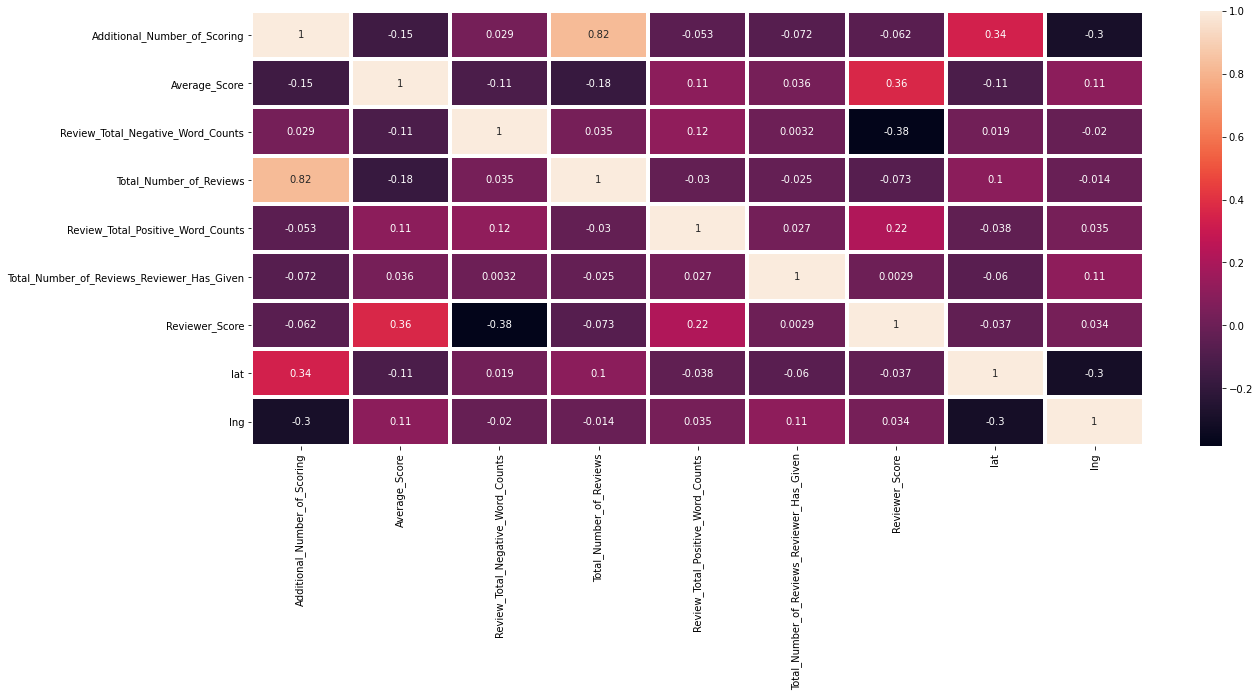

In [8]:
plt.figure(figsize=(20, 8))
corr = hotel_reviews.corr()
sns.heatmap(corr, linewidths=3, annot=True)

In [9]:
non_text_hr = hotel_reviews[["Average_Score", "Review_Total_Negative_Word_Counts", "Review_Total_Positive_Word_Counts", "Reviewer_Score"]]

In [10]:
non_text_hr

,Average_Score,Review_Total_Negative_Word_Counts,Review_Total_Positive_Word_Counts,Reviewer_Score
0,7.7,397,11,2.9
1,7.7,0,105,7.5
2,7.7,42,21,7.1
3,7.7,210,26,3.8
4,7.7,140,8,6.7
...,...,...,...,...
515733,8.1,14,2,7.0
515734,8.1,11,11,5.8
515735,8.1,19,0,2.5
515736,8.1,0,25,8.8


In [11]:
text_hr = hotel_reviews[["Hotel_Name", "Reviewer_Nationality", "Negative_Review", "Positive_Review"]]
text_hr

,Hotel_Name,Reviewer_Nationality,Negative_Review,Positive_Review
0,Hotel Arena,Russia,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...
1,Hotel Arena,Ireland,No Negative,No real complaints the hotel was great great ...
2,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...
3,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...
4,Hotel Arena,New Zealand,You When I booked with your company on line y...,Amazing location and building Romantic setting
...,...,...,...,...
515733,Atlantis Hotel Vienna,Kuwait,no trolly or staff to help you take the lugga...,location
515734,Atlantis Hotel Vienna,Estonia,The hotel looks like 3 but surely not 4,Breakfast was ok and we got earlier check in
515735,Atlantis Hotel Vienna,Egypt,The ac was useless It was a hot week in vienn...,No Positive
515736,Atlantis Hotel Vienna,Mexico,No Negative,The rooms are enormous and really comfortable...


In [12]:
# Review score

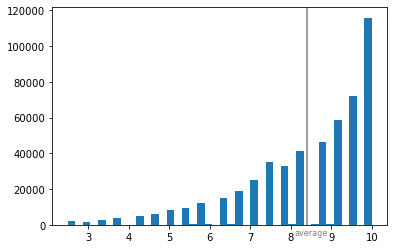

In [13]:
plt.figure()
plt.hist(non_text_hr['Reviewer_Score'], bins=40)
plt.axvline(non_text_hr["Reviewer_Score"].mean(), color = "grey")
plt.text(8.1,-6000, "average", fontsize = 8, color = "grey")
plt.show()

In [14]:
print(f'Total negative word count: {non_text_hr.Review_Total_Negative_Word_Counts.sum()}, Total positive word count {non_text_hr.Review_Total_Positive_Word_Counts.sum()}')

Total negative word count: 9561499, Total positive word count 9167995


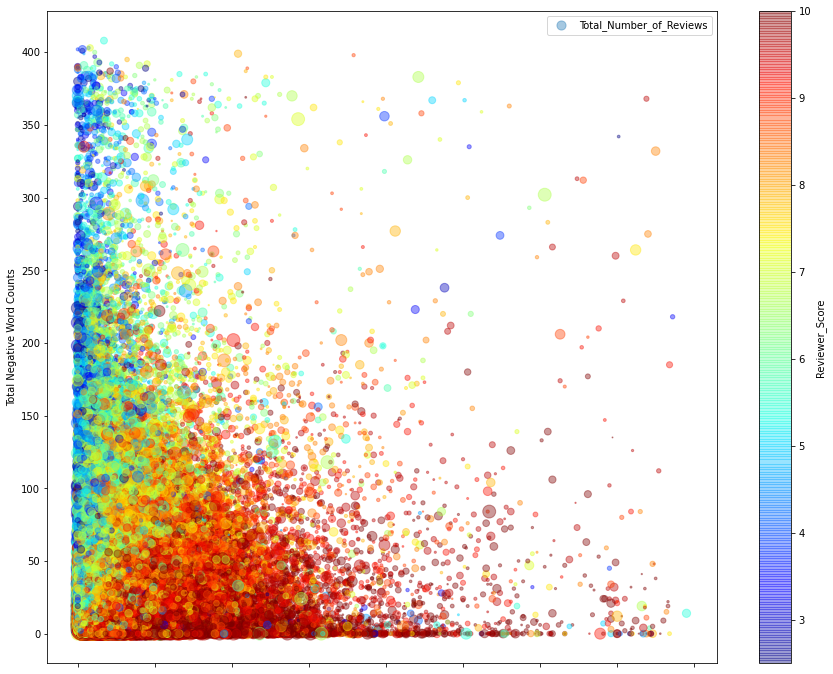

In [15]:
hotel_reviews.plot(kind='scatter', x='Review_Total_Positive_Word_Counts', y='Review_Total_Negative_Word_Counts', label='Total_Number_of_Reviews',s=hotel_reviews.Total_Number_of_Reviews/100,c='Reviewer_Score', cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, figsize=(15,12))
plt.xlabel("Total Positive Word Counts")
plt.ylabel("Total Negative Word Counts")
plt.legend()
plt.show()

In [16]:
hotel_reviews.Reviewer_Nationality.value_counts()[:20]

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
 France                         7296
 Israel                         6610
 Italy                          6114
 Belgium                        6031
 Turkey                         5444
 Kuwait                         4920
 Spain                          4737
 Romania                        4552
 Russia                         3900
 South Africa                   3821
Name: Reviewer_Nationality, dtype: int64

In [17]:
# Replace No Negative and No positive comments

In [18]:
hotel_reviews.loc[:, 'Positive_Review'] = hotel_reviews.Positive_Review.apply(lambda x: x.replace('No Positive', 'NA'))
hotel_reviews.loc[:, 'Negative_Review'] = hotel_reviews.Negative_Review.apply(lambda x: x.replace('No Negative', 'NA'))

In [19]:
hotel_reviews['Negative_Review'][1]

'NA'

In [20]:
# The dataset has no dependent variable/label, so I create one

In [21]:
hotel_reviews.Negative_Review

0          I am so angry that i made this post available...
1                                                        NA
2          Rooms are nice but for elderly a bit difficul...
3          My room was dirty and I was afraid to walk ba...
4          You When I booked with your company on line y...
                                ...                        
515733     no trolly or staff to help you take the lugga...
515734             The hotel looks like 3 but surely not 4 
515735     The ac was useless It was a hot week in vienn...
515736                                                   NA
515737         I was in 3rd floor It didn t work Free Wife 
Name: Negative_Review, Length: 515738, dtype: object

In [22]:
text_hr['review'] = text_hr.Positive_Review + text_hr.Negative_Review

<ipython-input-22-8d167c390aa3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_hr['review'] = text_hr.Positive_Review + text_hr.Negative_Review


In [23]:
text_hr['tgt_review'] = non_text_hr["Reviewer_Score"].apply(lambda x: "bad" if x<6 else "good")

<ipython-input-23-a674320e0f90>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_hr['tgt_review'] = non_text_hr["Reviewer_Score"].apply(lambda x: "bad" if x<6 else "good")


In [24]:
text_hr

,Hotel_Name,Reviewer_Nationality,Negative_Review,Positive_Review,review,tgt_review
0,Hotel Arena,Russia,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,Only the park outside of the hotel was beauti...,bad
1,Hotel Arena,Ireland,No Negative,No real complaints the hotel was great great ...,No real complaints the hotel was great great ...,good
2,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...,Location was good and staff were ok It is cut...,good
3,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...,Great location in nice surroundings the bar a...,bad
4,Hotel Arena,New Zealand,You When I booked with your company on line y...,Amazing location and building Romantic setting,Amazing location and building Romantic settin...,good
...,...,...,...,...,...,...
515733,Atlantis Hotel Vienna,Kuwait,no trolly or staff to help you take the lugga...,location,location no trolly or staff to help you take ...,good
515734,Atlantis Hotel Vienna,Estonia,The hotel looks like 3 but surely not 4,Breakfast was ok and we got earlier check in,Breakfast was ok and we got earlier check in ...,bad
515735,Atlantis Hotel Vienna,Egypt,The ac was useless It was a hot week in vienn...,No Positive,No Positive The ac was useless It was a hot we...,bad
515736,Atlantis Hotel Vienna,Mexico,No Negative,The rooms are enormous and really comfortable...,The rooms are enormous and really comfortable...,good


In [25]:
reviews = text_hr[['review', 'tgt_review']]

In [26]:
reviews

,review,tgt_review
0,Only the park outside of the hotel was beauti...,bad
1,No real complaints the hotel was great great ...,good
2,Location was good and staff were ok It is cut...,good
3,Great location in nice surroundings the bar a...,bad
4,Amazing location and building Romantic settin...,good
...,...,...
515733,location no trolly or staff to help you take ...,good
515734,Breakfast was ok and we got earlier check in ...,bad
515735,No Positive The ac was useless It was a hot we...,bad
515736,The rooms are enormous and really comfortable...,good


In [27]:
reviews[reviews.tgt_review == 'good'].head(10)

,review,tgt_review
1,No real complaints the hotel was great great ...,good
2,Location was good and staff were ok It is cut...,good
4,Amazing location and building Romantic settin...,good
5,Good restaurant with modern design great chil...,good
7,Good location Set in a lovely park friendly s...,good
8,No Positive Even though the pictures show very...,good
9,The room was big enough and the bed is good T...,good
10,Rooms were stunningly decorated and really sp...,good
13,This hotel is being renovated with great care...,good
14,It was very good very historic building that ...,good


In [28]:
reviews[reviews.tgt_review == 'bad'].head(10)

,review,tgt_review
0,Only the park outside of the hotel was beauti...,bad
3,Great location in nice surroundings the bar a...,bad
6,The room is spacious and bright The hotel is ...,bad
11,Style location rooms 6 30 AM started big nois...,bad
12,Comfy bed good location The floor in my room...,bad
21,The breakfast was the only positive element o...,bad
22,The location is good You need 15min to 20min ...,bad
32,No Positive Our bathroom had an urine order Sh...,bad
42,Love the design of the renovated product The ...,bad
44,The brunch to purchase in the morning was goo...,bad


<AxesSubplot:xlabel='tgt_review', ylabel='count'>

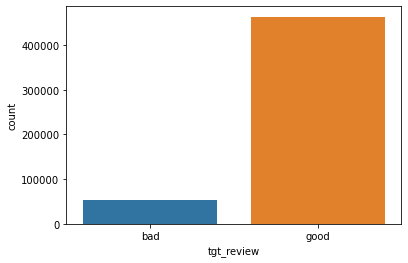

In [29]:
sns.countplot(x="tgt_review", data=reviews)

In [30]:
good_reviews = reviews[reviews.tgt_review=='good']
bad_reviews = reviews[reviews.tgt_review=='bad']

In [31]:
!pip install wordcloud
from wordcloud import WordCloud,STOPWORDS


In [32]:
def generate_wc(comment_words):
    stopwords = set(STOPWORDS) 

    wc = WordCloud(width=800, height=400, background_color="white", max_font_size=300, stopwords = stopwords).generate(comment_words)
    plt.figure(figsize=(14,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.show()

In [33]:
good_reviews_text = " ".join(good_reviews.review.to_numpy().tolist())

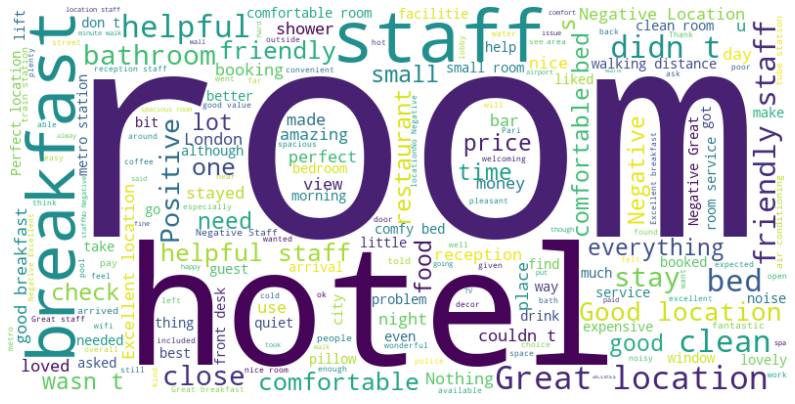

In [34]:
generate_wc(good_reviews_text)

In [35]:
bad_reviews_text = " ".join(bad_reviews.review.to_numpy().tolist())

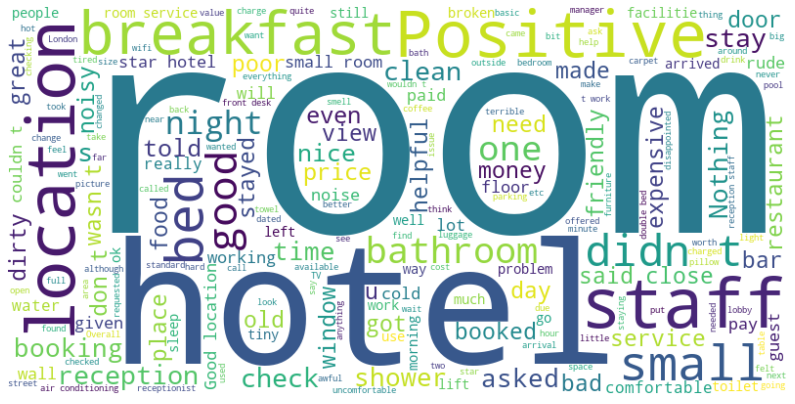

In [36]:
generate_wc(bad_reviews_text)

In [37]:
!python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg')

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


2022-09-12 17:39:33.635145: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-09-12 17:39:33.635214: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [38]:
ex_bad = bad_reviews.review[6]
ex_good = good_reviews.review[2]

In [39]:
token_bad = nlp(ex_bad)
token_good = nlp(ex_good)

In [40]:
for token in token_bad:
     print(f'{token.text:15} {token.pos_:15} {token.tag_:15} {token.dep_:15} {token.lemma_}')

                SPACE           _SP             dep              
The             DET             DT              det             the
room            NOUN            NN              nsubj           room
is              AUX             VBZ             ccomp           be
spacious        ADJ             JJ              acomp           spacious
and             CCONJ           CC              cc              and
bright          ADJ             JJ              conj            bright
The             DET             DT              det             the
hotel           NOUN            NN              nsubjpass       hotel
is              AUX             VBZ             auxpass         be
located         VERB            VBN             conj            locate
in              ADP             IN              prep            in
a               DET             DT              det             a
quiet           ADJ             JJ              amod            quiet
and             CCONJ           CC     

In [41]:
for token in token_good:
     print(f'{token.text:15} {token.pos_:15} {token.tag_:15} {token.dep_:15} {token.lemma_}')

                SPACE           _SP             dep              
Location        PROPN           NNP             nsubj           Location
was             AUX             VBD             ROOT            be
good            ADJ             JJ              acomp           good
and             CCONJ           CC              cc              and
staff           NOUN            NN              nsubj           staff
were            AUX             VBD             conj            be
ok              ADJ             JJ              punct           ok
It              PRON            PRP             nsubj           it
is              AUX             VBZ             ROOT            be
cute            ADJ             JJ              amod            cute
hotel           NOUN            NN              attr            hotel
the             DET             DT              det             the
breakfast       NOUN            NN              compound        breakfast
range           NOUN            NN    

In [42]:
displacy.render(token_bad)

In [43]:
displacy.render(token_good)

In [44]:
good_df = good_reviews.sample(n=len(bad_reviews), random_state=42)
review_resampled = good_df.append(bad_reviews).reset_index(drop=True)
review_resampled.shape

(105014, 2)

In [45]:
review_resampled.head()

,review,tgt_review
0,The beautiful hotel is situated at an excelle...,good
1,Lovely suite excellent spa facility comfortab...,good
2,Location close to Metro bar prices Price che...,good
3,Its clow from all important things to visit i...,good
4,Great location just off trafalger staff were ...,good


<AxesSubplot:xlabel='tgt_review', ylabel='count'>

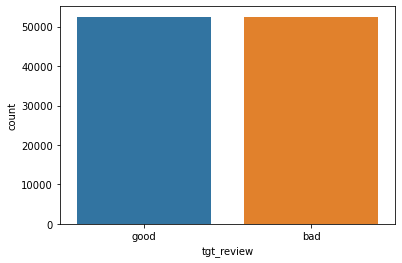

In [46]:
sns.countplot(x="tgt_review", data=review_resampled)

In [47]:
from sklearn import preprocessing
label_enc = preprocessing.LabelEncoder()
encoded_review = label_enc.fit_transform(review_resampled.tgt_review.values)

In [48]:
X = review_resampled[['review']]
y = review_resampled['tgt_review']

train_reviews, test_reviews, y_train, y_test = train_test_split(review_resampled.review, encoded_review, test_size=0.15, random_state=42)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(review_resampled.review, encoded_review, test_size=0.15, random_state=7)

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [51]:
tvec = TfidfVectorizer()
clf = LogisticRegression(solver = "lbfgs")

In [52]:
model = Pipeline([('vectorizer', tvec), ('classifier', clf)])
model.fit(X_train, y_train)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression())])

In [53]:
predictions = model.predict(X_test)

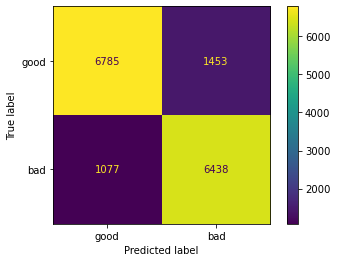

In [54]:
cm = confusion_matrix(predictions, y_test)
cmd = ConfusionMatrixDisplay(cm, display_labels=['good','bad'])
cmd.plot()

In [55]:
from sklearn.metrics import precision_score, recall_score
print("Accuracy: ", accuracy_score(predictions, y_test))
print("Precision: ", precision_score(predictions, y_test, average = 'weighted'))
print("Recall: ", recall_score(predictions, y_test, average = 'weighted'))

Accuracy:  0.8393956706659049
Precision:  0.8405209682679612
Recall:  0.8393956706659049


In [56]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      8238
           1       0.82      0.86      0.84      7515

    accuracy                           0.84     15753
   macro avg       0.84      0.84      0.84     15753
weighted avg       0.84      0.84      0.84     15753



In [57]:
ex = ["I'm unsatisfied"]
result = model.predict(ex)
print(result)

[0]


In [58]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
print(le.classes_)

['bad' 'good']


In [59]:
from googletrans import Translator

In [60]:
translator = Translator()

In [64]:
data_trans = {'review': ['Great place to stay, but noisy and on a main road. Neat accommodation, we had a quadruple room with a loft. Kitchen and bathroom and sitting area. Neat towels and shower utensils. It is a building where several accommodations are next to each other, it is quite noisy! The building is on a main road!',
               'Good. Really nice room',
               'Strategic location, delightful owner, clean and functional for a passing night. Delightful and caring owner. Nothing to complain, among other things he recommended a very good restaurant where to dine and an excellent pastry bar where to have breakfast with a small agreement. For a passing night it is perfect!',
               'I loved it and I might as well repeat it.',
               'Good location. Really small for the price paid',
               'Cute. The owner was very helpful and nice The room was clean The location of the farm is near the lake. The apartment we stayed in instead of having a normal double bed was a creaking sofa bed, plus there was a noise like a pump being discharged every half hour. The farmhouse is located in front of the road on a very busy road and, although soundproofed, you can hear all the vehicles passing by',
               'cozy but expensive. smell in the rooms and high price.',
               'Passable. It is located on a through road but during the night there are no cars, so it is quiet. There are no windows, not even in the bathroom (forced ventilation) but only the French window from which you enter the room. Big fridge but too noisy during the night, I had to turn it off',
               'I am sure I am not going back. non-existent cleaning',
               'Disappointing. Very small room, the toilet cannot be used by a person taller than 1.70 cm and the bidet is unusable due to non-existent space. Cleaning not at all thorough, uncomfortable bed and two slices like pillows.'],
              
    
}
df_trans = pd.DataFrame(data_trans)
print(df_trans)

                                              review
0  Great place to stay, but noisy and on a main r...
1                             Good. Really nice room
2  Strategic location, delightful owner, clean an...
3          I loved it and I might as well repeat it.
4     Good location. Really small for the price paid
5  Cute. The owner was very helpful and nice The ...
6  cozy but expensive. smell in the rooms and hig...
7  Passable. It is located on a through road but ...
8  I am sure I am not going back. non-existent cl...
9  Disappointing. Very small room, the toilet can...


In [69]:
review1 = ["Great place to stay, but noisy and on a main road. Neat accommodation, we had a quadruple room with a loft. Kitchen and bathroom and sitting area. Neat towels and shower utensils. It is a building where several accommodations are next to each other, it is quite noisy! The building is on a main road!"]
pred_rev1 = model.predict(review1)
print(pred_rev1)

[1]


In [70]:
review2 = ["Good. Really nice room"]
pred_rev2 = model.predict(review2)
print(pred_rev2)

[1]


In [71]:
review7 = ["cozy but expensive. smell in the rooms and high price."]
pred_rev7 = model.predict(review7)
print(pred_rev7)

[1]


In [74]:
review9 = ["I am sure I am not going back. non-existent cleaning"]
pred_rev9 = model.predict(review9)
print(pred_rev9)

[0]


In [75]:
review10 = ["Disappointing. Very small room, the toilet cannot be used by a person taller than 1.70 cm and the bidet is unusable due to non-existent space. Cleaning not at all thorough, uncomfortable bed and two slices like pillows."]
pred_rev10 = model.predict(review10)
print(pred_rev10)

[0]
